<a href="https://colab.research.google.com/github/Obamium37/Brain-Tumor-Detection/blob/main/Tumor%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import classification_report
from keras.preprocessing import image
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
train_dir = "/content/drive/MyDrive/train"
test_dir = "/content/drive/MyDrive/test"
specified_test_dir = '/content/drive/MyDrive/detection_tester'

In [30]:
# Set the image dimensions
img_width, img_height = 150, 150

# Set the number of training and test samples
train_samples = sum([len(files) for _, _, files in os.walk(train_dir)])
test_samples = sum([len(files) for _, _, files in os.walk(test_dir)])
specified_test_samples = sum([len(files) for _, _, files in os.walk(specified_test_dir)])

In [53]:
# Set the number of epochs and batch size
epochs = 20
batch_size = 50

In [54]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

In [55]:
# Only normalization for the test set
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess the training set
train_set = train_datagen.flow_from_directory(train_dir,
                                              target_size=(img_width, img_height),
                                              batch_size=batch_size,
                                              class_mode='binary')

# Load and preprocess the test set
test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size=(img_width, img_height),
                                            batch_size=batch_size,
                                            class_mode='binary')

Found 253 images belonging to 2 classes.
Found 6 images belonging to 2 classes.


In [56]:
# Build the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [57]:
train_acc = []
train_loss = []

# Custom callback to track training accuracy
class TrainingAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_acc.append(logs['accuracy'])

model.fit(train_set,
          steps_per_epoch=train_samples // batch_size,
          epochs=epochs,
          validation_data=test_set,
          validation_steps=test_samples // batch_size,
          callbacks=[TrainingAccuracyCallback()])

Epoch 1/20
5/5 [==============================] - 18s 3s/step - loss: 1.6021 - accuracy: 0.5160
Epoch 2/20
5/5 [==============================] - 9s 2s/step - loss: 0.6675 - accuracy: 0.6305
Epoch 3/20
5/5 [==============================] - 8s 1s/step - loss: 0.6141 - accuracy: 0.6404
Epoch 4/20
5/5 [==============================] - 11s 2s/step - loss: 0.5888 - accuracy: 0.7340
Epoch 5/20
5/5 [==============================] - 9s 2s/step - loss: 0.5702 - accuracy: 0.6995
Epoch 6/20
5/5 [==============================] - 8s 1s/step - loss: 0.5582 - accuracy: 0.7192
Epoch 7/20
5/5 [==============================] - 10s 2s/step - loss: 0.5349 - accuracy: 0.7537
Epoch 8/20
5/5 [==============================] - 8s 2s/step - loss: 0.5182 - accuracy: 0.7635
Epoch 9/20
5/5 [==============================] - 10s 1s/step - loss: 0.4902 - accuracy: 0.7537
Epoch 10/20
5/5 [==============================] - 10s 2s/step - loss: 0.4945 - accuracy: 0.7685
Epoch 11/20
5/5 [===========================

In [58]:
# Make predictions on the test set
y_pred = model.predict(test_set)
y_pred = np.round(y_pred)

# Convert the predictions to binary labels
y_pred = [int(pred[0]) for pred in y_pred]

# Get the true labels
y_true = test_set.classes

# Generate a classification report
report = classification_report(y_true, y_pred)
print(report)

1/1 [==============================] - 0s 342ms/step
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       1.00      0.33      0.50         3

    accuracy                           0.67         6
   macro avg       0.80      0.67      0.62         6
weighted avg       0.80      0.67      0.62         6



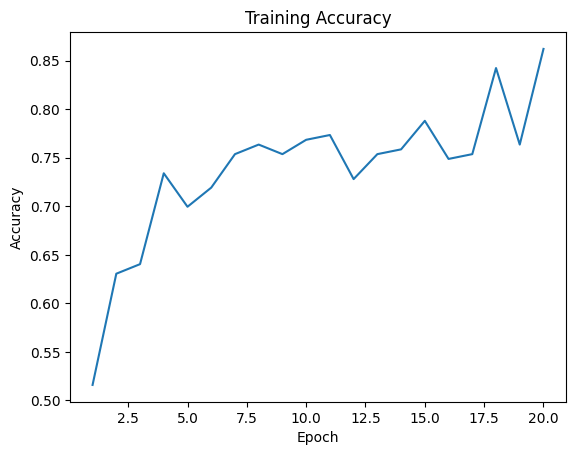

In [59]:
# Plot training accuracy
plt.plot(range(1, epochs+1), train_acc)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

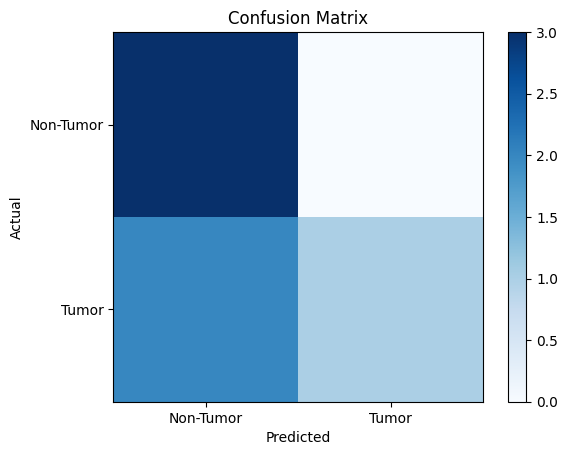

In [60]:
cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0, 1], ['Non-Tumor', 'Tumor'])
plt.yticks([0, 1], ['Non-Tumor', 'Tumor'])
plt.colorbar()
plt.show()

In [61]:
# Function to classify a single image
class_labels = {0: 'Non-Tumor', 1: 'Tumor'}
def classify_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_width, img_height))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize the image

    prediction = model.predict(img)
    class_index = int(np.round(prediction)[0][0])



    if class_index == 1:
      return 'Tumor'
    else:
      return 'Non-Tumor'



# Specify the path to the image file in the test folder
image_path = '/content/drive/MyDrive/test/yes/Y42.jpg'  # Replace with the path to your test image

# Classify the image
pred = classify_image(image_path)



print("Image Classification:", pred)

1/1 [==============================] - 0s 98ms/step
Image Classification: Tumor
